In [1]:
from tensorflow.keras import models, layers, utils
import matplotlib.pyplot as pyplot
import tensorflow as tf

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/tomasz/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 


In [3]:
from sklearn.preprocessing import label_binarize

y_bin_train = label_binarize(y_train, classes=[*range(10)])
y_bin_test = label_binarize(y_test, classes=[*range(10)])

In [4]:
y_bin_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [5]:
model = models.Sequential()

# Pierwsza warstwa konwolucyjna
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Druga warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# trzecia warstwa konwolucyjna
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))


# czwarta warstwa konwolucyjna
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

# Zamiana trójwymiarowej macierzy na jednowymiarowy wektor (przestawienie kolejnych wierszy kolumn liniowo)
model.add(layers.Flatten())

# Sieć neuronowa
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
____

In [6]:
x_train[0].shape

(32, 32, 3)

In [7]:

model.compile(optimizer='sgd',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:



x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255




In [9]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 98s 2ms/sample - loss: 2.2768 - acc: 0.1260 - val_loss: 2.2261 - val_acc: 0.2042
Epoch 2/10
50000/50000 [==============================] - 92s 2ms/sample - loss: 2.1174 - acc: 0.2015 - val_loss: 2.0520 - val_acc: 0.2369
Epoch 3/10
50000/50000 [==============================] - 96s 2ms/sample - loss: 2.0362 - acc: 0.2354 - val_loss: 2.1278 - val_acc: 0.2065
Epoch 4/10
50000/50000 [==============================] - 97s 2ms/sample - loss: 1.9544 - acc: 0.2698 - val_loss: 1.9496 - val_acc: 0.2972
Epoch 5/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 1.8746 - acc: 0.2962 - val_loss: 1.7737 - val_acc: 0.3541
Epoch 6/10
50000/50000 [==============================] - 119s 2ms/sample - loss: 1.7974 - acc: 0.3302 - val_loss: 1.7056 - val_acc: 0.3817
Epoch 7/10
50000/50000 [==============================] - 156s 3ms/sample - loss: 1.7310 - acc: 0.3619 - val_loss:

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5010654041290283
Test accuracy: 0.4566


In [9]:
import numpy as np

def zamien(y_pred):
    res = np.empty((y_pred.shape[0], 10))
    for pred in range(len(y_pred)):
        pres = np.empty(10)
        for i in range(10):
            if i == y_pred[pred]:
                pres[i] = 1
            else:
                pres[i] = 0
        res[pred] = pres
    return res

def zmaksuj(y_pred):
    res = np.array(y_pred, copy=True)
    for pred in range(len(y_pred)):
        argmax = y_pred[pred].argmax()
        for i in range(10):
            if i == argmax:
                res[pred][i] = 1
            else:
                res[pred][i] = 0
    return res
                
        

In [35]:
from sklearn.metrics import log_loss

y_zmodelu = model.predict(x_test)
log_loss(y_test, y_zmodelu)

4.038689547200501

array([[2.37889158e-02, 1.46007613e-02, 1.31677842e-01, ...,
        4.70285293e-02, 1.15706764e-02, 3.86237877e-02],
       [8.40601035e-02, 6.03852302e-01, 9.71220267e-04, ...,
        2.47050504e-04, 2.44410466e-01, 6.55844384e-02],
       [6.78701404e-02, 6.98859334e-01, 2.13034387e-03, ...,
        1.70106619e-03, 1.04588525e-01, 1.20351885e-01],
       ...,
       [6.28645318e-04, 1.60141854e-04, 2.86529278e-02, ...,
        1.78825169e-01, 3.74211153e-04, 1.38603350e-03],
       [3.68728181e-01, 4.80125931e-01, 1.08121964e-02, ...,
        9.48315566e-03, 1.90461828e-02, 6.13002895e-02],
       [4.40202777e-03, 4.69468660e-03, 7.09033414e-02, ...,
        6.33877340e-01, 9.22996329e-04, 8.44490073e-03]])

In [15]:
layer_name = "flatten"
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)


intermediate_output = intermediate_layer_model.predict(x_train)

In [16]:
intermediate_output.shape

(50000, 128)

In [17]:
from sklearn import svm

clf = svm.SVC(kernel='linear', probability=True)

clf.fit(intermediate_output, y_train)

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [34]:
from sklearn.metrics import accuracy_score

#y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))

accuracy_score(zamien(y_test), zmaksuj(y_pred))

0.5012

In [36]:
from sklearn.metrics import log_loss

log_loss(y_test, y_pred)

1.3803455788151744

In [41]:
#y_bin_pred = label_binarize(y_pred,  classes=[*range(10)])
#y_bin_pred

In [42]:
#y_bin_test

Text(0.5, 1.0, 'SVM P-R')

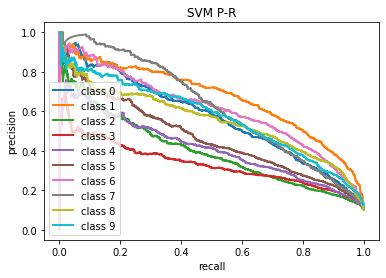

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("SVM P-R")

Text(0.5, 1.0, 'SVM ROC')

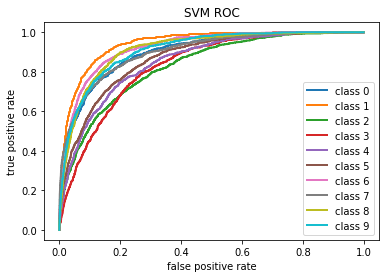

In [38]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("SVM ROC")

Text(0.5, 1.0, 'CNN P-R')

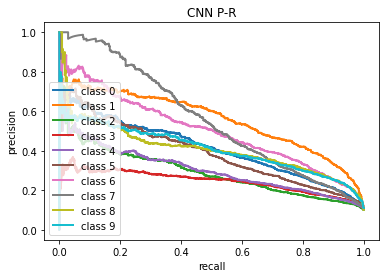

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
for i in range(10):
    p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(r, p, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("CNN P-R")

Text(0.5, 1.0, 'CNN ROC')

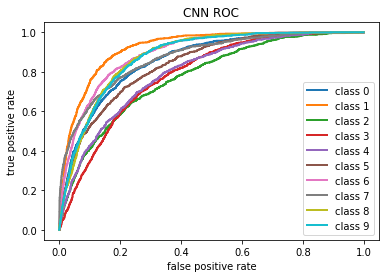

In [40]:
for i in range(10):
    fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
    plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))
    
plt.legend(loc="best")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("CNN ROC")

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 2.2772 - acc: 0.1338 - val_loss: 2.1581 - val_acc: 0.1918
Epoch 2/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 2.1141 - acc: 0.1992 - val_loss: 2.0864 - val_acc: 0.2197
Epoch 3/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 2.0362 - acc: 0.2311 - val_loss: 1.9980 - val_acc: 0.2679
Epoch 4/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.9464 - acc: 0.2650 - val_loss: 1.8604 - val_acc: 0.3098
Epoch 5/10
50000/50000 [==============================] - 82s 2ms/sample - loss: 1.8693 - acc: 0.2939 - val_loss: 1.7880 - val_acc: 0.3408
Epoch 6/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.7988 - acc: 0.3257 - val_loss: 1.7099 - val_acc: 0.3707
Epoch 7/10
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.7248 - acc: 0.3581 - val_loss: 1.

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wyniki po 10
Dla CNN
Test accuracy: 0.4439
Loss: 
4.180035164654255
Dla SVM
Accuracy: 
0.5399
Loss: 
1.2931698498503559
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 78s 2ms/sample - loss: 1.5124 - acc: 0.4432 - val_loss: 1.5482 - val_acc: 0.4503
Epoch 2/30
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.4721 - acc: 0.4585 - val_loss: 1.4179 - val_acc: 0.4850
Epoch 3/30
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.4360 - acc: 0.4746 - val_loss: 1.3955 - val_acc: 0.4976
Epoch 4/30
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.4025 - acc: 0.4870 - val_loss: 1.3289 - val_acc: 0.5289
Epoch 5/30
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.3735 - acc: 0.5035 - val_loss: 1.2721 - val_acc: 0.5465
Epoch 6/30
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.3430 - acc: 0.5144 - val_loss: 1.2626 - val_acc: 0.5

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wyniki po 40
Dla CNN
Test accuracy: 0.6816
Loss: 
2.3496509991683068
Dla SVM
Accuracy: 
0.7178
Loss: 
0.8416263440648439
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.9211 - acc: 0.6789 - val_loss: 0.8839 - val_acc: 0.6901
Epoch 2/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.9070 - acc: 0.6830 - val_loss: 0.8940 - val_acc: 0.6908
Epoch 3/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.9036 - acc: 0.6837 - val_loss: 0.8857 - val_acc: 0.6933
Epoch 4/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.8949 - acc: 0.6899 - val_loss: 0.9686 - val_acc: 0.6679
Epoch 5/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.8808 - acc: 0.6952 - val_loss: 0.8798 - val_acc: 0.6918
Epoch 6/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.8770 - acc: 0.6945 - val_loss: 0.8625 - val_acc: 0.

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wyniki po 80
Dla CNN
Test accuracy: 0.7511
Loss: 
1.9985657283723355
Dla SVM
Accuracy: 
0.7635
Loss: 
0.734757346315464
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6674 - acc: 0.7692 - val_loss: 0.8050 - val_acc: 0.7255
Epoch 2/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6640 - acc: 0.7688 - val_loss: 0.7123 - val_acc: 0.7539
Epoch 3/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6586 - acc: 0.7710 - val_loss: 0.7283 - val_acc: 0.7511
Epoch 4/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6507 - acc: 0.7749 - val_loss: 0.8073 - val_acc: 0.7203
Epoch 5/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6479 - acc: 0.7749 - val_loss: 0.7058 - val_acc: 0.7584
Epoch 6/40
50000/50000 [==============================] - 76s 2ms/sample - loss: 0.6474 - acc: 0.7750 - val_loss: 0.7169 - val_acc: 0.7

/home/tomasz/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Wyniki po 120
Dla CNN
Test accuracy: 0.7675
Loss: 
2.001166969124228
Dla SVM
Accuracy: 
0.7816
Loss: 
0.7558667286279469


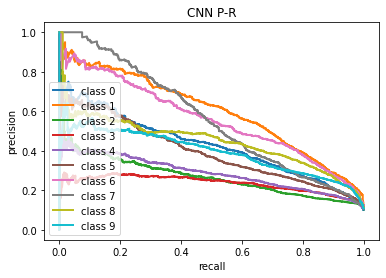

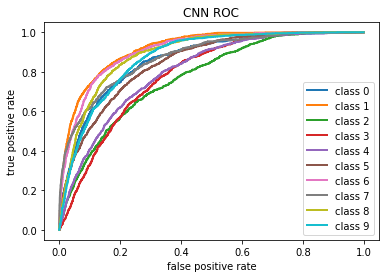

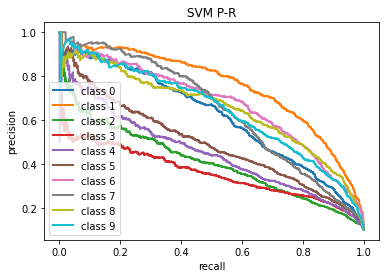

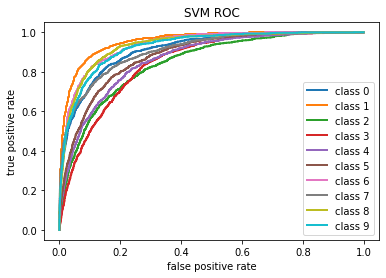

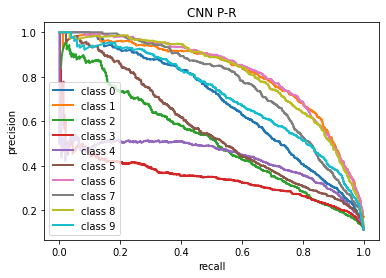

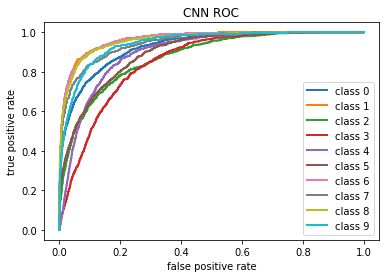

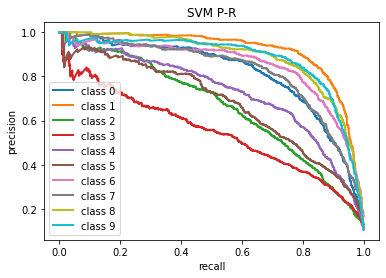

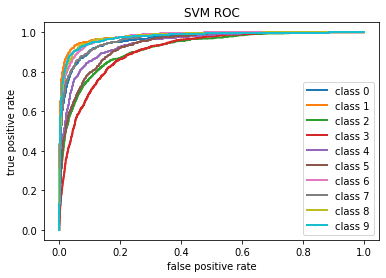

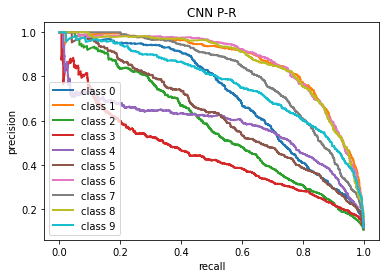

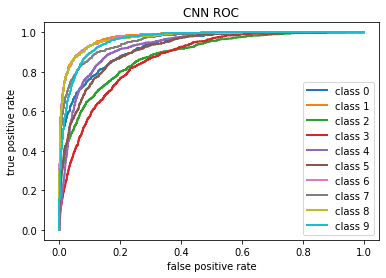

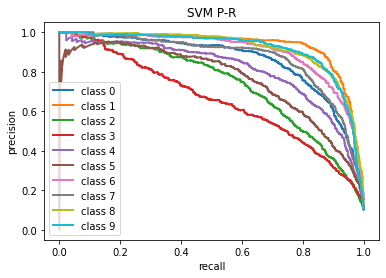

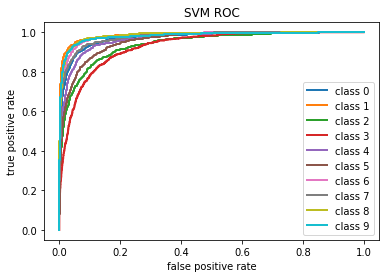

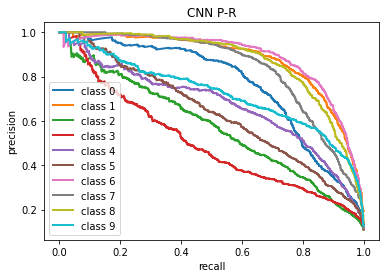

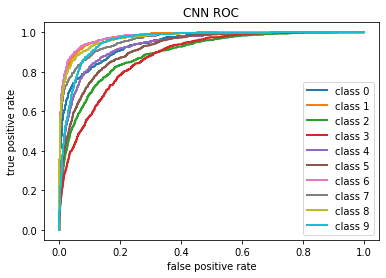

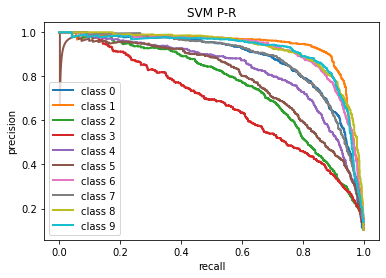

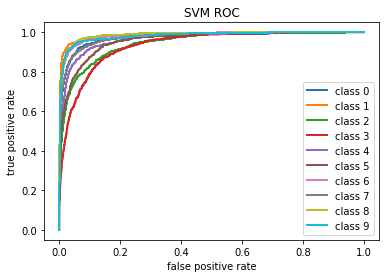

In [10]:
#Potezne badania
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import log_loss
from sklearn import svm
from sklearn.metrics import accuracy_score

# czyli po 10, po 40, po 80 i po 120
epoki = [10, 30, 40, 40]
epoki_h = [10, 40, 80, 120]

for IT in range(len(epoki)):
    #trening CNN
    history = model.fit(x_train, y_train, epochs=epoki[IT], batch_size=64, validation_data=(x_test, y_test))
    
    #model wyciagajacy wektory przed MLP
    layer_name = "flatten"
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    #wektory przed MLP
    intermediate_output = intermediate_layer_model.predict(x_train)
    
    #trening SVM
    clf = svm.SVC(probability=True)
    clf.fit(intermediate_output, y_train)
    
    print("Wyniki po "+str(epoki_h[IT]))
    
    #ocena CNN
    print("Dla CNN")
    score = model.evaluate(x_test, y_test, verbose=0)
    #print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_zmodelu = model.predict(x_test)
    print("Loss: ")
    print(log_loss(y_test, y_zmodelu))
    
    plt.figure()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt.plot(r, p, lw=2, label='class {}'.format(i))
    
    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("CNN P-R")
    
    plt.figure()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_zmodelu[:, i])
        plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("CNN ROC")
    
    #ocena SVM
    print("Dla SVM")
    y_pred = clf.predict_proba(intermediate_layer_model.predict(x_test))
    print("Accuracy: ")
    print(accuracy_score(zamien(y_test), zmaksuj(y_pred)))
    print("Loss: ")
    print(log_loss(y_test, y_pred))
    
    plt.figure()
    for i in range(10):
        p, r, _ = precision_recall_curve(y_bin_test[:, i], y_pred[:, i])
        plt.plot(r, p, lw=2, label='class {}'.format(i))

    plt.legend(loc="best")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title("SVM P-R")
    
    plt.figure()
    for i in range(10):
        fpr, tpr, _ = roc_curve(y_bin_test[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, lw=2, label='class {}'.format(i))

    plt.legend(loc="best")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.title("SVM ROC")
    